In [60]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import keras.layers as klayers
import keras.models as kmodel
import keras.callbacks as kcallbacks
import keras.optimizers as koptimizers


In [9]:
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')
df.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [10]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime( 
    year=row['year'], month=row['month'], day=row['day'], hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

Text(0.5, 1.0, 'Box plot of Air Pressure')

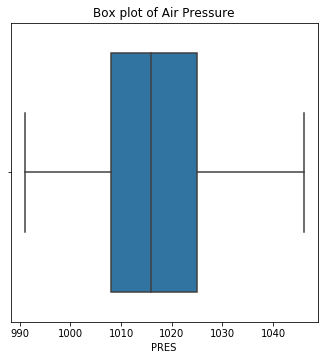

In [11]:
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

Text(0, 0.5, 'Air Pressure readings in hPa')

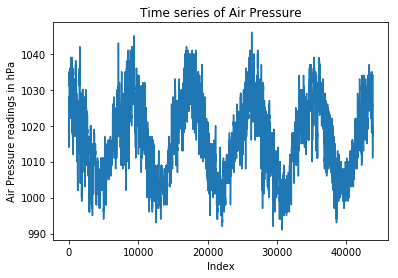

In [20]:
g = sns.lineplot(df.index,df['PRES'])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure readings in hPa')

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

In [16]:
# Train: from 2010-2013, Validation: 2014
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


Text(0, 0.5, 'Scaled Air Pressure readings')

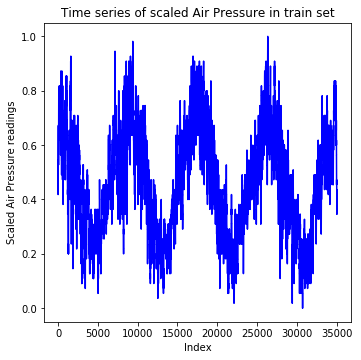

In [22]:
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(df_train.index, df_train['scaled_PRES'], color='b') 
g.set_title('Time series of scaled Air Pressure in train set') 
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

Text(0, 0.5, 'Standardized Air Pressure readings')

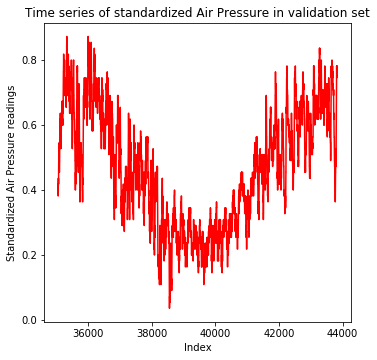

In [23]:
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(df_val.index, df_val['scaled_PRES'], color='r')
g.set_title('Time series of standardized Air Pressure in validation set')
g.set_xlabel('Index')
g.set_ylabel('Standardized Air Pressure readings')

In [87]:
def makeXy(ts, nb_timesteps):
    """
    Input:
        s: original time series
        nb_timesteps: number of time steps in the regressors
    Output:
        X: 2-D array of regressors
        y: 1-D array of target
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        piece = ts.iloc[i-nb_timesteps:i]
        X.append(list(piece))
        y.append(ts.iloc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [88]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)


Shape of train arrays: (35057, 7) (35057,)
Shape of validation arrays: (8753, 7) (8753,)


In [89]:
input_layer = klayers.Input(shape=(7,), dtype='float32')

In [90]:
dense1 = klayers.Dense(32, activation='linear')(input_layer)
dense2 = klayers.Dense(16, activation='linear')(dense1)
dense3 = klayers.Dense(16, activation='linear')(dense2)
dropout_layer = klayers.Dropout(0.2)(dense3)
output_layer = klayers.Dense(1, activation='linear')(dropout_layer)

In [91]:
ts_model = kmodel.Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')
ts_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


In [93]:
#os.mkdir('keras_models')
save_weights_at = os.path.join('keras_models','PRSA_data_Air_Pressure_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = kcallbacks.ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=False, mode='min', period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20, verbose=1, 
             callbacks=[save_best], validation_data=(X_val, y_val), shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 4s 113us/step - loss: 0.0138 - val_loss: 3.4018e-04
Epoch 2/20
35057/35057 [==============================] - 4s 100us/step - loss: 0.0017 - val_loss: 8.3401e-04
Epoch 3/20
35057/35057 [==============================] - 3s 100us/step - loss: 9.5455e-04 - val_loss: 3.6428e-04
Epoch 4/20
35057/35057 [==============================] - 3s 94us/step - loss: 8.3868e-04 - val_loss: 1.5398e-04
Epoch 5/20
35057/35057 [==============================] - 3s 98us/step - loss: 8.3609e-04 - val_loss: 3.6556e-04
Epoch 6/20
35057/35057 [==============================] - 4s 103us/step - loss: 8.0252e-04 - val_loss: 1.6256e-04
Epoch 7/20
35057/35057 [==============================] - 4s 103us/step - loss: 7.8175e-04 - val_loss: 1.9783e-04
Epoch 8/20
35057/35057 [==============================] - 4s 101us/step - loss: 7.8773e-04 - val_loss: 1.6883e-04
Epoch 9/20
35057/35057 [=========================

In [94]:
best_model = kmodel.load_model(os.path.join('keras_models','PRSA_data_Air_Pressure_MLP_weights.15-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)


In [95]:
r2 = r2_score(df_val['PRES'].iloc[7:], pred_PRES)
print('R-squared for the validation set:', round(r2,4))

R-squared for the validation set: 0.9957


Text(0.5, 0, 'Index')

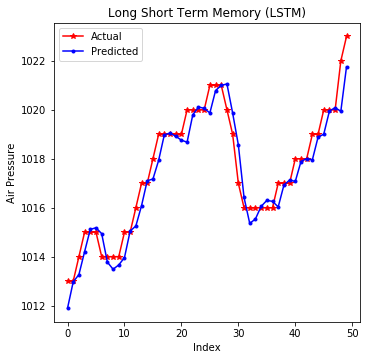

In [108]:
#Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].iloc[7:57], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Multi-Layer Perceptrons (MLP)')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

Text(0.5, 1.0, 'Box plot of pm2.5')

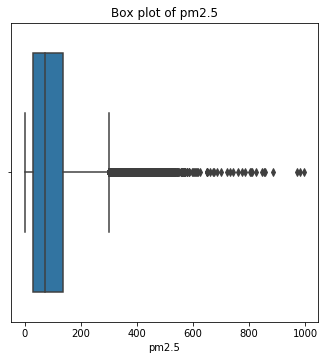

In [99]:
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['pm2.5'])
g.set_title('Box plot of pm2.5')


/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'pm2.5 readings')

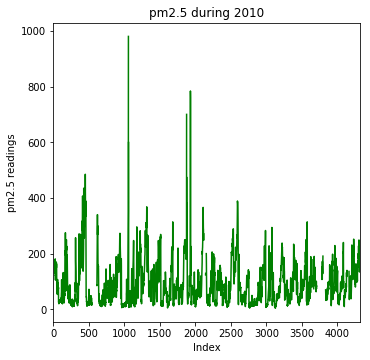

In [103]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['pm2.5'].loc[df['datetime']<=datetime.datetime(year=2010,month=6,day=30)], color='g')
g.set_title('pm2.5 during 2010')
g.set_xlabel('Index')
g.set_ylabel('pm2.5 readings')

/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'pm2.5 readings')

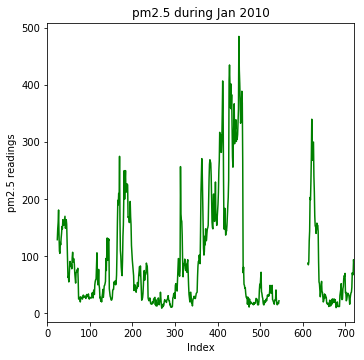

In [104]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['pm2.5'].loc[df['datetime']<=datetime.datetime(year=2010, month=1,day=31)], color='g')
g.set_title('pm2.5 during Jan 2010')
g.set_xlabel('Index')
g.set_ylabel('pm2.5 readings')

Text(0, 0.5, 'pm2.5 readings')

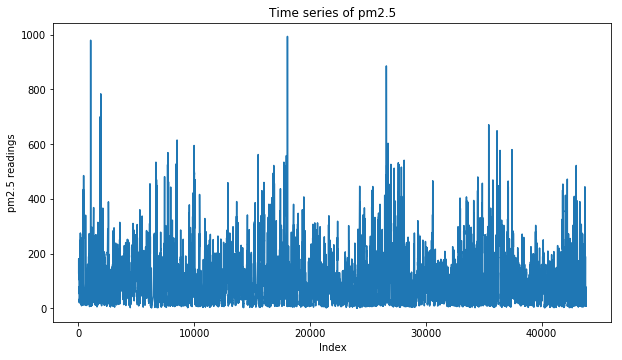

In [106]:
plt.figure(figsize=(10, 5.5))
g = sns.lineplot(df.index,df['pm2.5'])
g.set_title('Time series of pm2.5')
g.set_xlabel('Index')
g.set_ylabel('pm2.5 readings')

In [107]:
input_layer = klayers.Input(shape=(7,), dtype='float32')
dense1 = klayers.Dense(32, activation='tanh')(input_layer)
dense2 = klayers.Dense(16, activation='tanh')(dense1)
dense3 = klayers.Dense(16, activation='tanh')(dense2)
dropout_layer = klayers.Dropout(0.2)(dense3)
output_layer = klayers.Dense(1, activation='linear')(dropout_layer)
ts_model = kmodel.Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')